# RL Lecture 4: Model-free prediction

Prediction = Policy evaluation

Notes from a Reinformcement Course by David Silver (https://www.youtube.com/watch?v=PnHCvfgC_ZA&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&index=4)

We are getting rid of the assumption, that we know the Markov Descision Process. In particular, we don't know what the reward is in each state and what are the probabilities what state we are going to be at after taking an action.

## Easy21
Assignment for a Reinforcement Learning Course, mentioned at 16:15.

We are playing a simplified version of Twenty One. We draw cards from an infinite deck of red and black cards with values from 1 to 10. We start with a score of 0. If we drew red (probability of 1/3), we subtract the value we got from the score and add if we drew black. At the start both player and the dealer draw one black card. The goal is to get highest possible value without exceeding 21 or gowing below 1.

Dealer's strategy is to play until he exceeds 17.

We will not use Dynamic Programming here, even though we know how this MDP works. 

### 1. Implementation of Easy21

In [25]:
import random

import matplotlib.pyplot as plt
import numpy as np
from pylab import meshgrid

plt.style.use('fivethirtyeight')

In [2]:
def draw_card():
    u = random.random()
    color = 'black' if u < (2/3) else 'red'
    new_card = random.randint(1, 10)
    return new_card if color == 'black' else -new_card

class State:
    def __init__(self, dealer_value=None, player_value=None):
        self.dealer = dealer_value or random.randint(1, 10)
        self.player = player_value or random.randint(1, 10)
        
    def hit(self):
        new_card = draw_card()
        return State(self.dealer, self.player + new_card)
    
    def hit_dealer(self):
        new_card = draw_card()
        return State(self.dealer + new_card, self.player)
        
    def __str__(self):
        return f'State(dealer={self.dealer}, player={self.player})'
    
    def __repr__(self):
        return str(self)

In [3]:
def step(state, action):
    """Function simulating Easy21 evironment. Returns (state: State, reward: int)"""
    if action == 'stick':  # let the dealer play. we assume that player's value is valid
        while state.dealer < 17:
            state = state.hit_dealer()
        if state.dealer > 21 or state.dealer < 1:
            return state, 1
        elif state.player > state.dealer:
            return state, 1
        elif state.dealer > state.player:
            return state, -1
        else:
            return state, 0
    else:  # action == 'hit'
        state = state.hit()
        if state.player > 21 or state.player < 1:
            return state, -1
        else:
            return state, 0

In [9]:
random.seed(2)
state = State()
print(state)
state = state.hit()
print(state)
state = state.hit()
print(state)
state, reward = step(state, 'hit')
print('hitting')
print(state, reward)
if reward == 0:
    print('sticking')
    state, reward = step(state, 'stick')
    print(state, reward)

State(dealer=1, player=2)
State(dealer=1, player=5)
State(dealer=1, player=5)
hitting
State(dealer=1, player=15) 0
sticking
State(dealer=20, player=15) -1


### 2. Monte-Carlo Policy Evaluation in Easy21
We want to know what the value function is. Value function is a function that for each state returns it's expected discounted reward. State is just a tuple of dealer value (between 1 and 10) and player value (between 1 and 21). Of course it depends on policy, which we want to be optimal. We want to firstly set our policy $\pi: S \to A$.

In [56]:
def policy(state):
    "Policy to hit if we are below given threshold"
    threshold = 17
    if state.player < state.dealer or state.player < threshold:
        return 'hit'
    else:
        return 'stick'

In [57]:
V = np.zeros([10, 21])  # value function
N = np.zeros([10, 21], dtype=np.int)  # counter of states
S = np.zeros([10, 21])  # total discounted reward of states
# note: we don't have to use total rewards variable. we can use online learning instead

In [58]:
# Single policy evaluation
state = State()
reward = 0
action = None
while reward == 0 and action != 'stick':  # it could be that reward is 0 after we called stick (draw)
    print(state, reward)
    action = policy(state)
    state, reward = step(state, action)
print('Final state: ', state, 'Reward:', reward)

State(dealer=10, player=8) 0
State(dealer=10, player=12) 0
State(dealer=10, player=9) 0
State(dealer=10, player=5) 0
State(dealer=10, player=11) 0
State(dealer=10, player=9) 0
State(dealer=10, player=16) 0
Final state:  State(dealer=10, player=23) Reward: -1


In [59]:
# Monte Carlo evaluation, no discounting (gamma=1), we count every visit to the state (not just the first one)
N_STEPS = 1_000_000
for n in range(N_STEPS):
    state = State()
    visited_states = list()
    reward = 0
    action = None
    while reward == 0 and action != 'stick':  # it could be that reward is 0 after we called stick (draw)
        visited_states.append(state)
        action = policy(state)
        state, reward = step(state, action)
    for state in visited_states:  # each visited state has valid dealer and player values
        N[state.dealer - 1, state.player - 1] += 1
        S[state.dealer - 1, state.player - 1] += reward

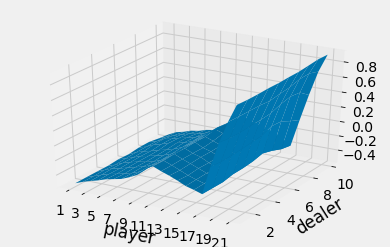

In [60]:
value_function = S / N
X,Y = meshgrid(np.arange(1, 22), np.arange(1, 11))
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, value_function)
plt.xlabel('player')
plt.ylabel('dealer')
xint = range(1, 22, 2)
plt.xticks(xint);

How does a value function change given a delaer value?

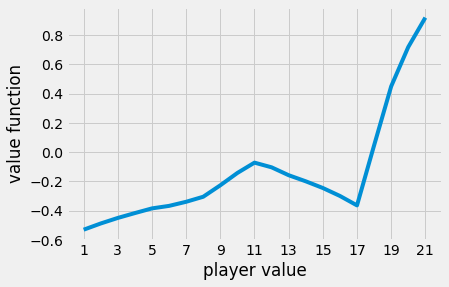

In [61]:
dealer_value = 9
plt.plot(np.arange(1, 22), value_function[dealer_value - 1, :])
plt.xticks(np.arange(1, 22, 2))
plt.xlabel('player value')
plt.ylabel('value function');

Value function changes a lot for our policy, depending on what value we have.

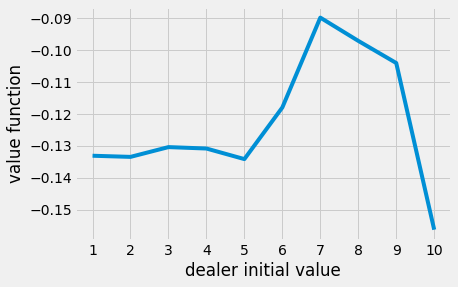

In [62]:
player_value = 12
plt.plot(np.arange(1, 11), value_function[:, player_value - 1])
plt.xticks(np.arange(1, 11));
plt.xlabel('dealer initial value')
plt.ylabel('value function');

For dealer initial value, our value function barely changes.